In [1]:
import valenspy as vp
from valenspy.preprocessing_tasks.regrid import remap_cdo
from dask.diagnostics import ProgressBar
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt

# Load the data
## ERA-5


In [2]:
manager = vp.InputManager(machine="hortense")
ds_ref = manager.load_data("ERA5","tas", period=2006,freq="hourly",region="europe")
ds_ref

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/2m_temperature/era5-hourly-europe-2m_temperature-2006.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']


<xarray.Dataset> Size: 3GB
Dimensions:  (lon: 289, lat: 163, time: 8760)
Coordinates:
  * lon      (lon) float32 1kB -27.0 -26.75 -26.5 -26.25 ... 44.5 44.75 45.0
  * lat      (lat) float32 652B 73.5 73.25 73.0 72.75 ... 33.75 33.5 33.25 33.0
  * time     (time) datetime64[ns] 70kB 2006-01-01 ... 2006-12-31T23:00:00
Data variables:
    tas      (time, lat, lon) float64 3GB dask.array<chunksize=(3024, 56, 99), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-02-19 04:37:50 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...
    period:       2006
    freq:         hourly
    region:       europe
    dataset:      ERA5

## ALARO_SFX - AEROSOL
Alaro sfx data with MERRA2 aerosol data

TODO - Load more data (whole 6Ms)

In [28]:
data_dir = Path("/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/CORDEXbeII/run_ALARO_sfx/out/netcdf/6M_CObeII_ERA5_25_12_ALARO_SFX_EUROCORDEX")
files = list(data_dir.glob("*.nc"))
files

[PosixPath('/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/CORDEXbeII/run_ALARO_sfx/out/netcdf/6M_CObeII_ERA5_25_12_ALARO_SFX_EUROCORDEX/output_20060531.nc'),
 PosixPath('/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/CORDEXbeII/run_ALARO_sfx/out/netcdf/6M_CObeII_ERA5_25_12_ALARO_SFX_EUROCORDEX/output_20060601.nc'),
 PosixPath('/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/CORDEXbeII/run_ALARO_sfx/out/netcdf/6M_CObeII_ERA5_25_12_ALARO_SFX_EUROCORDEX/output_20060530.nc')]

In [5]:
ds = xr.open_mfdataset(files, combine='by_coords', chunks="auto")

# Data preperation
Preparing the loaded datasets for the diagnostics

## 1) Regridding using CDO
Regrdding the model data to the refernce grid ERA-5

In [6]:
!which cdo

/readonly/dodrio/apps/RHEL8/zen2-ib/software/CDO/2.1.1-gompi-2021a/bin/cdo


In [7]:
gridfile= "/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/daily/2m_temperature/era5-daily-europe-2m_temperature-2006.nc"
ds_regridded = remap_cdo(gridfile, ds, "bil")

In [8]:
ds_regridded

<xarray.Dataset> Size: 339MB
Dimensions:                    (time: 72, lon: 289, lat: 163)
Coordinates:
  * time                       (time) datetime64[ns] 576B 2006-05-30T01:00:00...
  * lon                        (lon) float32 1kB -27.0 -26.75 ... 44.75 45.0
  * lat                        (lat) float32 652B 73.5 73.25 73.0 ... 33.25 33.0
Data variables: (12/25)
    cloudfraction              (time, lat, lon) float32 14MB dask.array<chunksize=(72, 163, 289), meta=np.ndarray>
    ground_heat_flux           (time, lat, lon) float32 14MB dask.array<chunksize=(72, 163, 289), meta=np.ndarray>
    latent_heat_flux           (time, lat, lon) float32 14MB dask.array<chunksize=(72, 163, 289), meta=np.ndarray>
    latent_heat_flux_transp    (time, lat, lon) float32 14MB dask.array<chunksize=(72, 163, 289), meta=np.ndarray>
    net_radiation              (time, lat, lon) float32 14MB dask.array<chunksize=(72, 163, 289), meta=np.ndarray>
    rain_convective            (time, lat, lon) float32 14MB dask.array<chunksize=(72, 163, 289), meta=np.ndarray>
    ...                         ...
    temperature_2m_atm         (time, lat, lon) float32 14MB dask.array<chunksize=(72, 163, 289), meta=np.ndarray>
    temperature_2m_sfx         (time, lat, lon) float32 14MB dask.array<chunksize=(72, 163, 289), meta=np.ndarray>
    temperature_surface        (time, lat, lon) float32 14MB dask.array<chunksize=(72, 163, 289), meta=np.ndarray>
    u_wind                     (time, lat, lon) float32 14MB dask.array<chunksize=(72, 163, 289), meta=np.ndarray>
    v_wind                     (time, lat, lon) float32 14MB dask.array<chunksize=(72, 163, 289), meta=np.ndarray>
    wind_speed_10m             (time, lat, lon) float32 14MB dask.array<chunksize=(72, 163, 289), meta=np.ndarray>
Attributes: (12/22)
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    basedate:     2006-05-30
    validate:     2006-05-30 01:00:00
    leadtime:     1
    timestep:     300
    ...           ...
    ex:           13
    ey:           13
    center_lon:   9.9
    center_lat:   49
    history:      Thu Jul 25 16:36:57 2024: cdo -O -s -f nc -remapbil,/dodrio...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

## 2) Time period
Select the time period of intersest

In [29]:
#Select the time period in dataset ref that overlaps with the dataset to compare
ds_ref = ds_ref.sel(time=slice(ds_regridded.time.min(), ds_regridded.time.max()))
ds_ref

<xarray.Dataset> Size: 27MB
Dimensions:  (lon: 289, lat: 163, time: 72)
Coordinates:
  * lon      (lon) float32 1kB -27.0 -26.75 -26.5 -26.25 ... 44.5 44.75 45.0
  * lat      (lat) float32 652B 73.5 73.25 73.0 72.75 ... 33.75 33.5 33.25 33.0
  * time     (time) datetime64[ns] 576B 2006-05-30T01:00:00 ... 2006-06-02
Data variables:
    tas      (time, lat, lon) float64 27MB dask.array<chunksize=(72, 56, 99), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.6
    history:           2020-02-19 04:37:50 GMT by grib_to_netcdf-2.16.0: /opt...
    dataset:           ERA5
    period:            2006
    freq:              hourly
    region:            europe
    path_identifiers:  ['-daily-']

## 2) Select region of intersest 
NOT DONE HERE - Select the region of interest - in this case a lat long box around Belgium

In [11]:
belgium = {"lat": [49.5, 51.5], "lon": [2.5, 6.5]}

# ds_ref_bel = ds_ref.sel(lat=slice(belgium["lat"][0], belgium["lat"][1]), lon=slice(belgium["lon"][0], belgium["lon"][1]))
# ds_regridded_daily_bel = ds_regridded_daily.sel(lat=slice(belgium["lat"][1], belgium["lat"][0]), lon=slice(belgium["lon"][0], belgium["lon"][1]))

## 3) Some renaming that should be done in an input convertor

In [30]:
#Rename temperature_2m_sfx to tas
ds_regridded_preped = ds_regridded.rename_vars({"temperature_2m_sfx":"tas"})
ds_regridded_preped

<xarray.Dataset> Size: 339MB
Dimensions:                    (time: 72, lon: 289, lat: 163)
Coordinates:
  * time                       (time) datetime64[ns] 576B 2006-05-30T01:00:00...
  * lon                        (lon) float32 1kB -27.0 -26.75 ... 44.75 45.0
  * lat                        (lat) float32 652B 73.5 73.25 73.0 ... 33.25 33.0
Data variables: (12/25)
    cloudfraction              (time, lat, lon) float32 14MB dask.array<chunksize=(72, 163, 289), meta=np.ndarray>
    ground_heat_flux           (time, lat, lon) float32 14MB dask.array<chunksize=(72, 163, 289), meta=np.ndarray>
    latent_heat_flux           (time, lat, lon) float32 14MB dask.array<chunksize=(72, 163, 289), meta=np.ndarray>
    latent_heat_flux_transp    (time, lat, lon) float32 14MB dask.array<chunksize=(72, 163, 289), meta=np.ndarray>
    net_radiation              (time, lat, lon) float32 14MB dask.array<chunksize=(72, 163, 289), meta=np.ndarray>
    rain_convective            (time, lat, lon) float32 14MB dask.array<chunksize=(72, 163, 289), meta=np.ndarray>
    ...                         ...
    temperature_2m_atm         (time, lat, lon) float32 14MB dask.array<chunksize=(72, 163, 289), meta=np.ndarray>
    tas                        (time, lat, lon) float32 14MB dask.array<chunksize=(72, 163, 289), meta=np.ndarray>
    temperature_surface        (time, lat, lon) float32 14MB dask.array<chunksize=(72, 163, 289), meta=np.ndarray>
    u_wind                     (time, lat, lon) float32 14MB dask.array<chunksize=(72, 163, 289), meta=np.ndarray>
    v_wind                     (time, lat, lon) float32 14MB dask.array<chunksize=(72, 163, 289), meta=np.ndarray>
    wind_speed_10m             (time, lat, lon) float32 14MB dask.array<chunksize=(72, 163, 289), meta=np.ndarray>
Attributes: (12/22)
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    basedate:     2006-05-30
    validate:     2006-05-30 01:00:00
    leadtime:     1
    timestep:     300
    ...           ...
    ex:           13
    ey:           13
    center_lon:   9.9
    center_lat:   49
    history:      Thu Jul 25 16:36:57 2024: cdo -O -s -f nc -remapbil,/dodrio...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

In [31]:
#Keep only tas for the comparison
ds_ref = ds_ref[["tas"]]
ds_regridded_preped = ds_regridded_preped[["tas"]]

# Diagnostics
TODO - Have a more refined set of diagnostics! 
- More 
- Beter looking "standard" plots
## Model2Ref
Comparing the model data to the ERA-5 Reference data on the same grid.

In [36]:
from valenspy.diagnostic import DiurnalCycleBias, SpatialBias, TemporalBias

In [37]:
with ProgressBar():
    ds_diurnalcyclebias = DiurnalCycleBias.apply(ds_ref, ds_regridded_preped)
    ds_spatial_bias = SpatialBias.apply(ds_ref, ds_regridded_preped)
    ds_temporal_bias = TemporalBias.apply(ds_ref, ds_regridded_preped)

Now lets plot the results

Text(0.5, 0.98, 'Bias in the diurnal cycle, spatial and temporal domain')

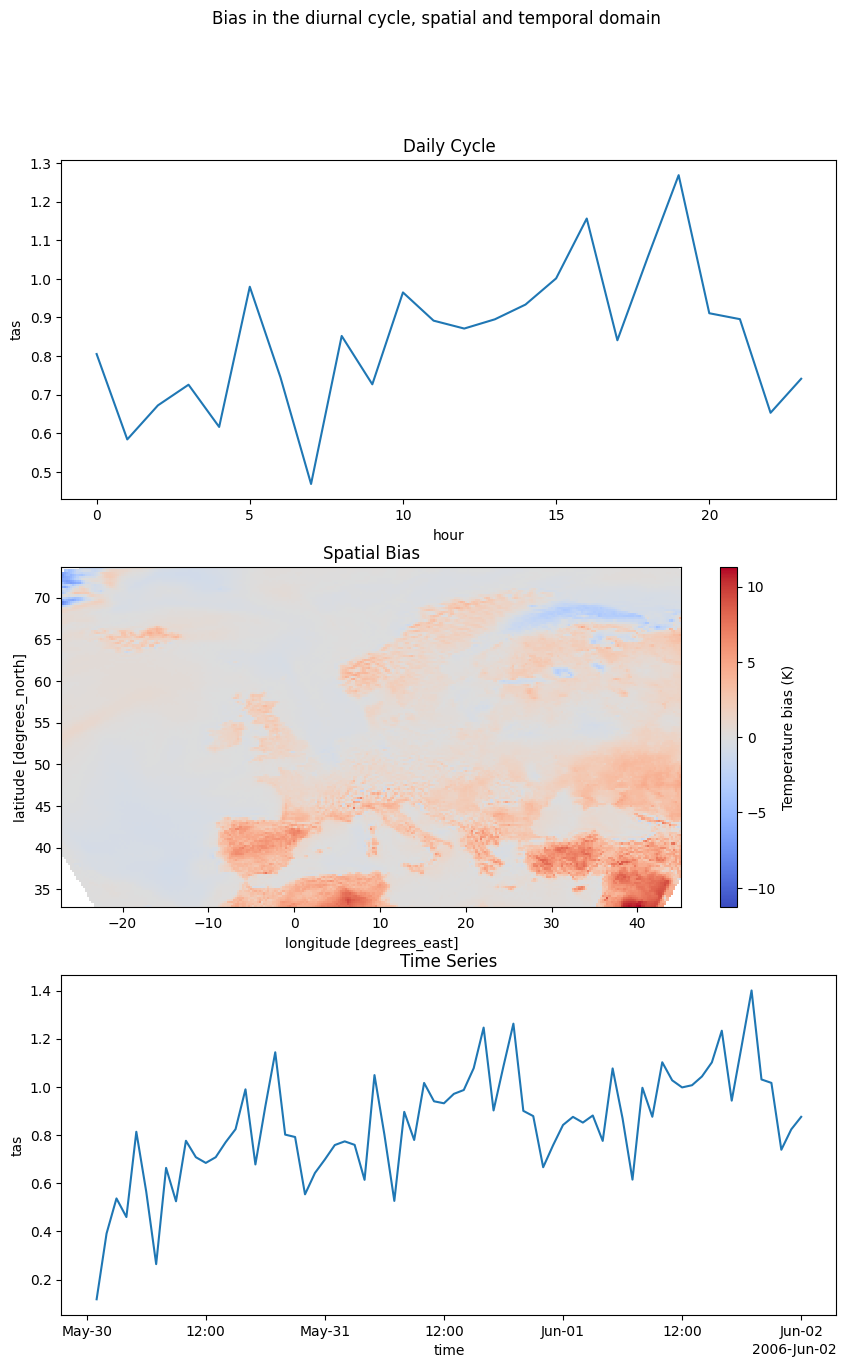

In [38]:
#Plot the results in 3 subplots under each other
fig, ax = plt.subplots(3,1, figsize=(10,15))
DiurnalCycleBias.plot(ds_diurnalcyclebias.tas, ax=ax[0])
SpatialBias.plot(ds_spatial_bias.tas, ax=ax[1])
TemporalBias.plot(ds_temporal_bias.tas, ax=ax[2])
#Add a title to the figure
fig.suptitle("Bias in the diurnal cycle, spatial and temporal domain")

# Archive
Needs to be updated - old analysis no longer working

## Model2Self

The change of the month is no longer visible in the model data this is good and implies that the previous error is fixed.

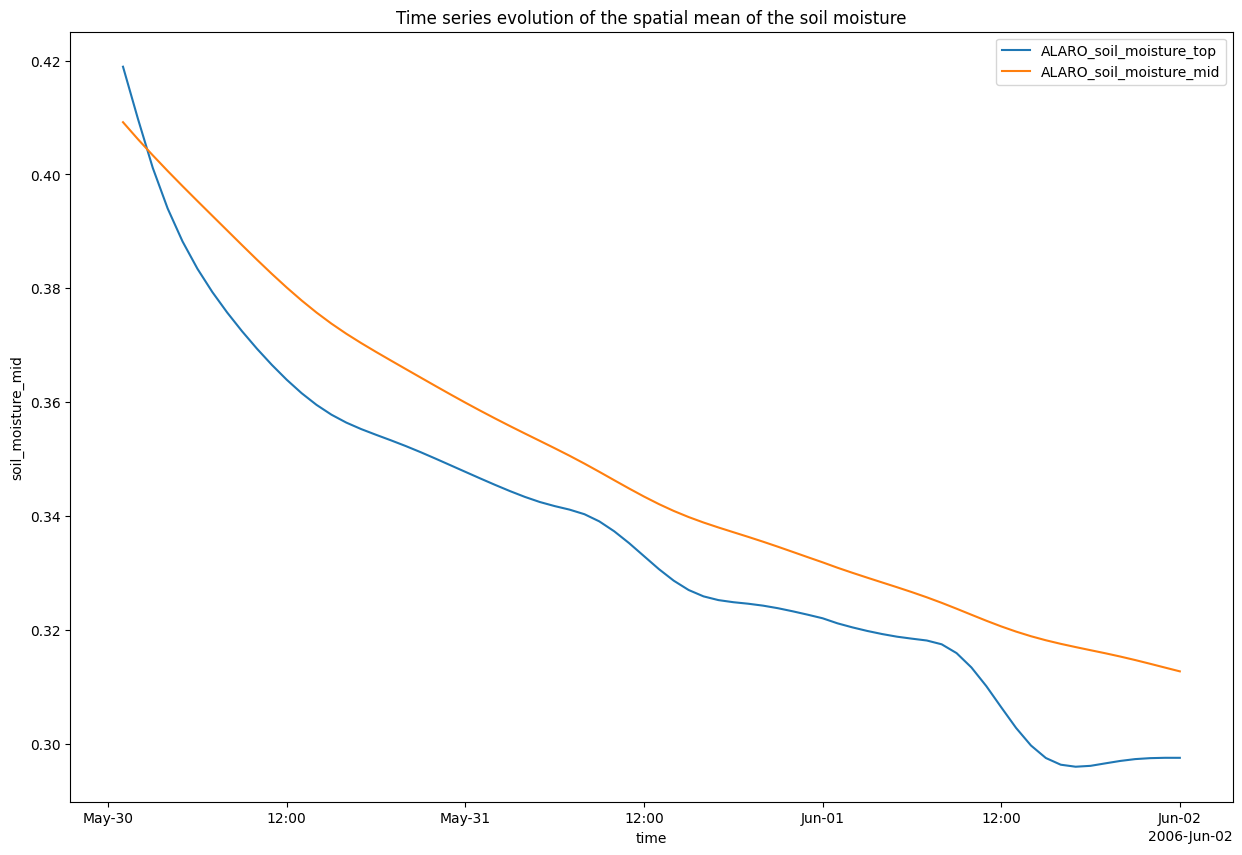

In [27]:
#Make a long plot
fig, ax = plt.subplots(figsize=(15,10))
vp_TimeSeriesSpatialMean.plot(ds_aero_spatial_avg.soil_moisture_top, ax=ax, label="ALARO_soil_moisture_top")
vp_TimeSeriesSpatialMean.plot(ds_aero_spatial_avg.soil_moisture_mid, ax=ax, label="ALARO_soil_moisture_mid")
ax.legend()
plt.title("Time series evolution of the spatial mean of the soil moisture")
plt.show()

## Wouts (12km) data
Wouts 12km data for comparison

In [21]:
#Wouts data 
data_dir_w = "/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/CORDEXbeII/run_ALARO_sfx/out/netcdf/wout_12km_runs"
files_w = list(Path(data_dir_w).glob("*.nc"))

ds_wout = xr.open_mfdataset(files_w, combine='by_coords', chunks="auto")

In [22]:
with ProgressBar():
    ds_w_aero_spatial_avg = ds_wout[["temperature_2m_sfx","soil_moisture_top","soil_moisture_mid"]].mean(dim=["x","y"]).compute()

[########################################] | 100% Completed | 185.79 s


### Soil Moisture
Having a look at the soil moisture of Wouts data.

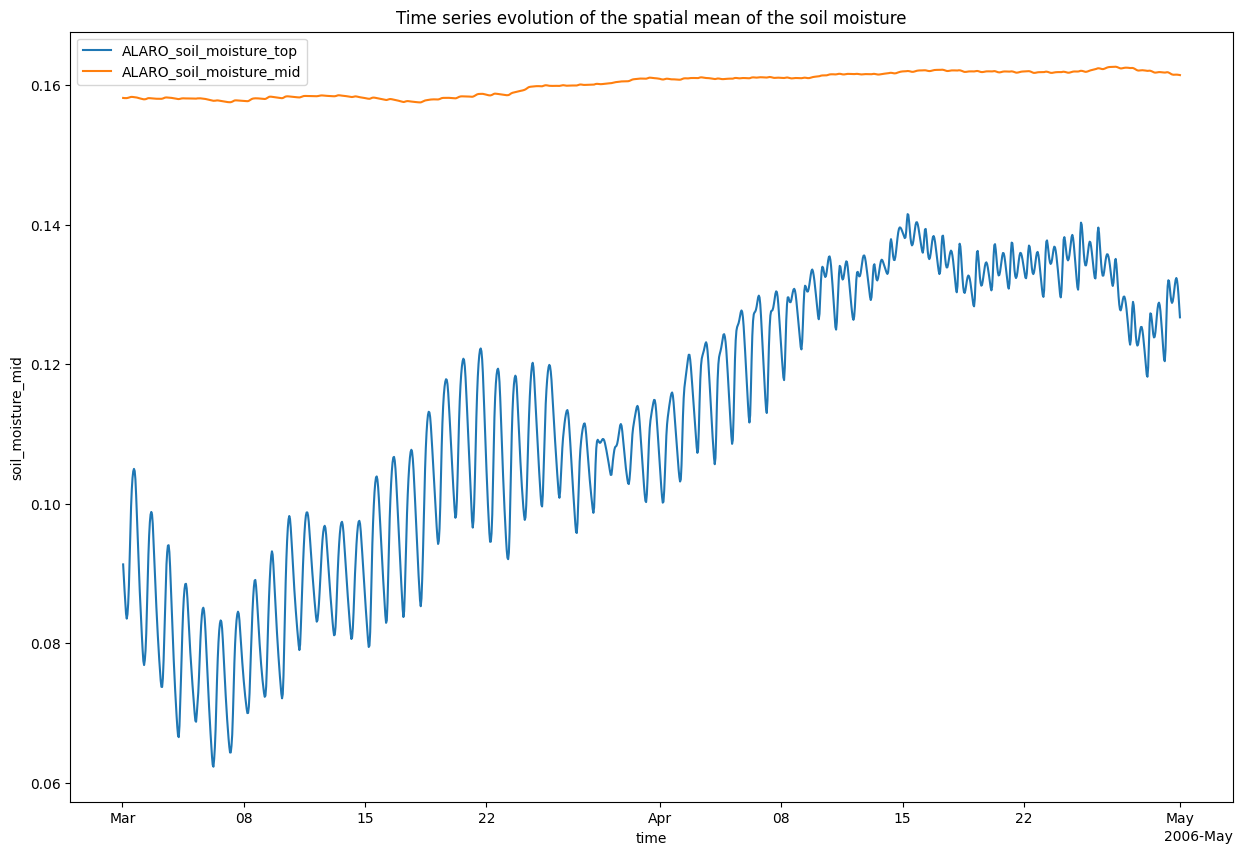

In [23]:
#Make a long plot
fig, ax = plt.subplots(figsize=(15,10))
vp_TimeSeriesSpatialMean.visualize(ds_w_aero_spatial_avg.soil_moisture_top, ax=ax, label="ALARO_soil_moisture_top")
vp_TimeSeriesSpatialMean.visualize(ds_w_aero_spatial_avg.soil_moisture_mid, ax=ax, label="ALARO_soil_moisture_mid")
ax.legend()
plt.title("Time series evolution of the spatial mean of the soil moisture")
plt.show()